In [1]:
import numpy as np
import scipy.integrate
import astropy as ast
%matplotlib inline
import matplotlib as mpl, matplotlib.pyplot as plt
import glob
import operator

mpl.rc('font', size=16)
mpl.rc('figure', figsize=(12,6))

In [2]:
# convert a string representation of a number
# of the sort produced by spherical_cloudy
# back into a numerical value, by replacing:
#     'd' with '.'
#     'p' with '+'
#     'n' with '-'
def deformat_string(s):
    return s.replace('d', '.').replace('p', '+').replace('m', '-')

ions = ['H I', 'D I', 'He I', 'He II']
nions = len(ions)

sph_cloudy_dtype = ([('rad', 'float64'), # radius
           ('temp', 'float64'),          # temperature
           ('hden', 'float64'),          # HI volume density
           ('HaSB', 'float64'),          # surface brightness in H-alpha
           ('tden', 'float64', nions),   # volume density for each species
           ('cden', 'float64', nions)])  # column density for each species

class SphCloudyResult:
    def __init__(self, fname):
        self.fname = fname
        self.data = np.load(fname)
        self.data.dtype = sph_cloudy_dtype
        
        # parse the file name to extract model parameters
        self.params = dict()
        fname_parts = fname.split('_')       
        for part in fname_parts:
            if(part == 'NFW'):
                self.params['profile'] = 'NFW'
            elif part.startswith('mass'):
                mass_str = deformat_string(part[4:])
                self.params['mass'] = float(mass_str)
            elif part.startswith('redshift'):
                z_str = deformat_string(part[8:])
                self.params['redshift'] = float(z_str)
            elif part.startswith('baryscl'):
                bary_str = deformat_string(part[7:])
                self.params['bary_scl'] = float(bary_str)
            elif part.startswith('Hescale'):
                He_str = deformat_string(part[7:])
                self.params['He_scl'] = float(He_str)
            else:
                # remaining part is nrad_nmu (.npy)
                nrad, nmu = (part.rstrip('.npy').split('-'))
                self.params['n_rad'] = nrad
                self.params['nmu'] = nmu

In [3]:
files = glob.glob('NFW*')

all_the_data = [SphCloudyResult(f) for f in files]

sorted_by_name = sorted(all_the_data, key=operator.attrgetter('fname'))

def compose(f, g):
    return lambda x: f(g(x))

sorted_by_Hescl = sorted(all_the_data, key=compose(operator.itemgetter('He_scl', 'mass'),operator.attrgetter('params')))

In [22]:
halomass, barymass = np.loadtxt('baryfrac.dat', unpack=True)
baryfracvals = 10**barymass / 10**halomass
virialm = np.linspace(8, 9, 20)
baryfrac = np.interp(virialm, halomass, baryfracvals)

NFW profile: $$\rho(r)=\frac{\rho_s}{\frac{r}{r_s}\left(1+\left(\frac{r}{r_s}\right)^2\right)}$$

In [24]:
# NFW density profile
def nfw(r, rs, rhos):
    return rhos / ((r/rs)*(1+(r/rs))**2)

rho_s = 10
r_s = 100
c = 10
r_vir = r_s * c

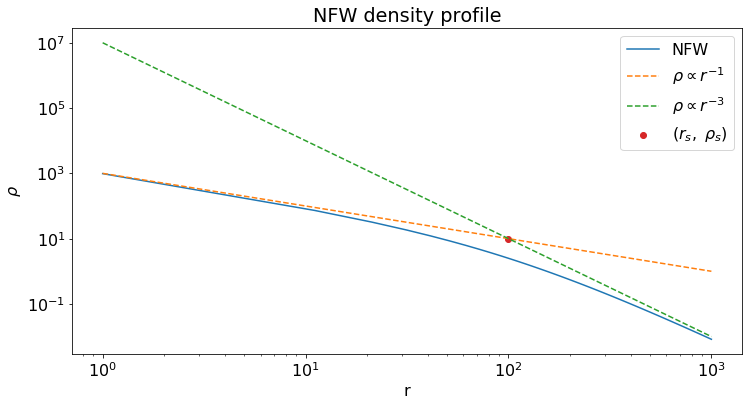

In [25]:
rads = np.linspace(1, r_vir, 100)
densities = nfw(rads, r_s, rho_s)

rad_to_minus_1 = rho_s / (rads/r_s)
rad_to_minus_3 = rho_s / (rads/r_s)**3

plt.figure()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('r')
ax.set_ylabel(r'$\rho$')
ax.set_title('NFW density profile')
plt.plot(rads, densities, label='NFW')
plt.plot(rads, rad_to_minus_1, '--', label=r'$\rho\propto r^{-1}$')
plt.plot(rads, rad_to_minus_3, '--', label=r'$\rho\propto r^{-3}$')
plt.scatter(r_s, rho_s, c='tab:red', label=r'$(r_s,\ \rho_s)$')
plt.legend();

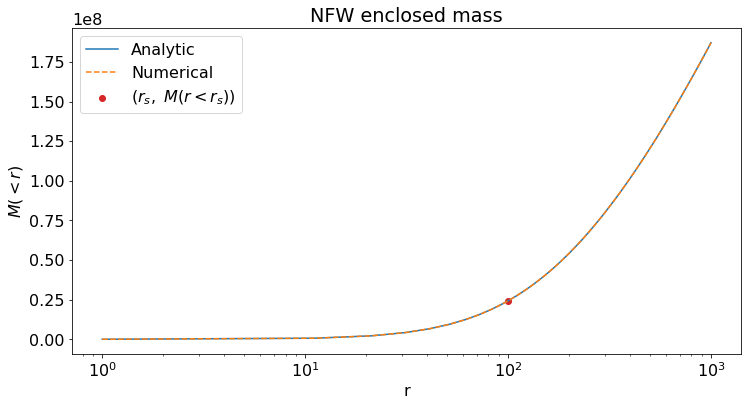

In [26]:
# Integrand for enclosed mass
def mass_integrand_numerical(r, rs, rhos):
    return 4 * np.pi * r**2 * nfw(r, rs, rhos)

# Analytic solution for enclosed mass
def mass_analytic(r, rs, rhos):
    return 4 * np.pi * rhos * rs**3 * (np.log((rs + r) / rs)- r / (rs + r)) 

ms_numerical = [scipy.integrate.quad(
    mass_integrand_numerical, 0., upper, args=(r_s, rho_s))[0] for upper in rads]
ms = m(rads, r_s, rho_s)
    
plt.figure()
ax = plt.gca()
ax.set_title('NFW enclosed mass')
ax.set_xscale('log')
ax.set_xlabel('r')
ax.set_ylabel(r'$M(<r)$')
plt.plot(rads, ms, label = 'Analytic')
plt.plot(rads, ms_numerical, '--', label='Numerical')
plt.scatter(r_s, m(r_s, r_s, rho_s), c='tab:red', label=r'$(r_s,\ M(r<r_s))$')
plt.legend();

In [32]:
# NFW profile in normalised coordinates
def nfw_norm(rtw, c, rho0):
    x = rtw * c
    return rho0 / (x*(1+x)**2)

# Enclosed mass integrand in normalised coordinates
def mass_integrand_numerical_norm(rtw, rvir, c, rho0):
    return 4 * np.pi * rtw**2 * rvir**3 * nfw_norm(rtw, c, rho0)

# Analytic solution for enclosed mass in normalised coordinates
def mass_analytic_norm(rtw, rvir, c, rho0):
    #return (4 * np.pi * rho0 / c**2) * np.arctan(rtw * c)
    #return (4 * np.pi * rho0 / c**3) * 0.5 * np.log((rtw*c)**2 + 1)
    x = rtw * c
    return (4 * np.pi * rho0 * rvir**3 / c**3) * (1 / (x + 1) + np.log(x + 1) - 1)

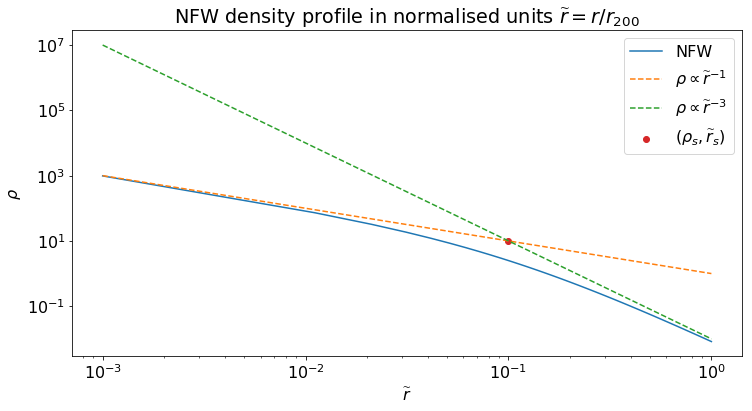

In [33]:
rs_norm = np.linspace(1 / r_vir, 1, 100)
densities_norm = nfw_norm(rs_norm, c, rho_s)

r_to_minus_1_norm = rho_s / (rs_norm * c)
r_to_minus_3_norm = rho_s / (rs_norm * c)**3

plt.figure()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\widetilde{r}$')
ax.set_ylabel(r'$\rho$')
ax.set_title(r'NFW density profile in normalised units $\widetilde{r}=r/r_{200}$')
plt.plot(rs_norm, densities_norm, label='NFW')
plt.plot(rs_norm, r_to_minus_1_norm, '--', label=r'$\rho\propto \widetilde{r}^{-1}$')
plt.plot(rs_norm, r_to_minus_3_norm, '--', label=r'$\rho\propto \widetilde{r}^{-3}$')
plt.scatter(r_s / r_vir, rho_s, c='tab:red', label=r'$(\rho_s, \widetilde{r}_s)$')
plt.legend();

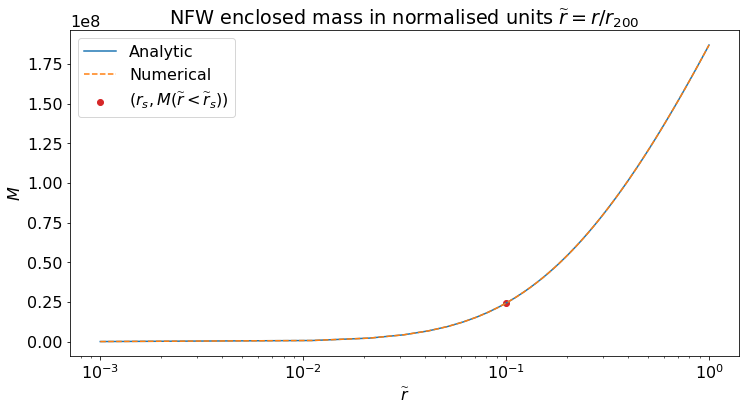

In [38]:
ms_norm = mass_analytic_norm(rs_norm, r_vir, c, rho_s)
ms_numerical_norm = [scipy.integrate.quad(
    mass_integrand_numerical_norm, 0., upper, args=(r_vir, c, rho_s))[0] for upper in rs_norm]
M_vir = mass_analytic_norm(1, r_vir, c, rho_s)

plt.figure()
ax = plt.gca()
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(r'$\widetilde{r}$')
ax.set_ylabel(r'$M$')
ax.set_title(r'NFW enclosed mass in normalised units $\widetilde{r}=r/r_{200}$')
plt.plot(rs_norm, ms_norm, label='Analytic')
plt.plot(rs_norm, ms_numerical_norm, '--', label='Numerical')
plt.scatter(r_s / r_vir, mass_analytic_norm(r_s / r_vir, r_vir, c, rho_s), c='tab:red', label=r'$(r_s, M(\widetilde{r}<\widetilde{r}_s))$')
plt.legend();

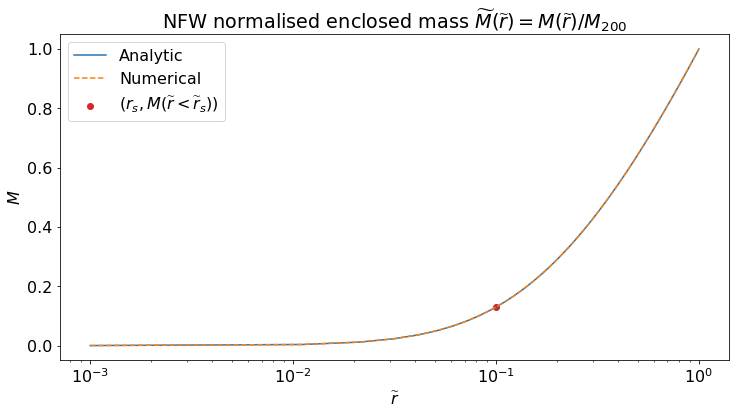

In [41]:
plt.figure()
ax = plt.gca()
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(r'$\widetilde{r}$')
ax.set_ylabel(r'$M$')
ax.set_title(r'NFW normalised enclosed mass $\widetilde{M}(\widetilde{r})=M(\widetilde{r})/M_{200}$')
plt.plot(rs_norm, ms_norm / M_vir, label='Analytic')
plt.plot(rs_norm, ms_numerical_norm / M_vir, '--', label='Numerical')
plt.scatter(r_s / r_vir, mass_analytic_norm(r_s / r_vir, r_vir, c, rho_s) / M_vir, c='tab:red', label=r'$(r_s, M(\widetilde{r}<\widetilde{r}_s))$')
plt.legend();

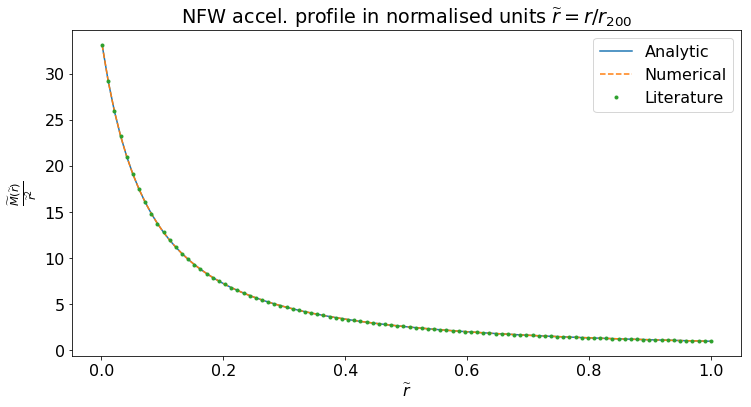

In [44]:
# Acceleration profile (M(<r)/r^2) from ABL et al in normalised coordinates
def accel_literature_norm(c, rtw):
    x = rtw * c
    return rtw**(-2) * (np.log(1 + x) - x/(1 + x)) / (np.log(1 + c) - c / (1 + c))

accels_norm = accel_literature_norm(c, rs_norm)

plt.figure()
ax = plt.gca()
ax.set_title(r'NFW accel. profile in normalised units $\widetilde{r}=r/r_{200}$')
ax.set_xlabel(r'$\widetilde{r}$')
ax.set_ylabel(r'$\frac{\widetilde{M}(\widetilde{r})}{\widetilde{r}^2}$')
#ax.set_xscale('log')
#ax.set_yscale('log')
plt.plot(rs_norm, ms_norm / (M_vir * rs_norm**2), label='Analytic')
plt.plot(rs_norm, ms_numerical_norm / (M_vir * rs_norm**2), '--', label='Numerical')
plt.plot(rs_norm, accels_norm, '.', label='Literature')
plt.legend();

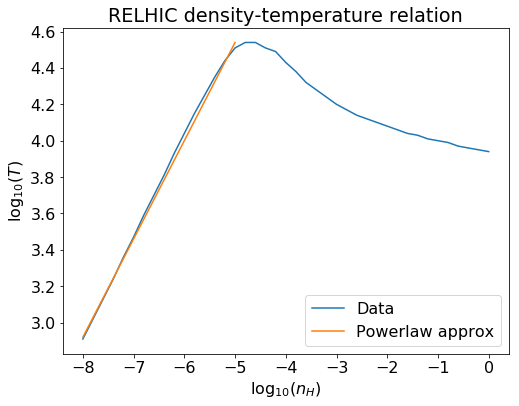

In [45]:
h_densities  = np.linspace(-8.0, 0.0, 41)
temperatures = np.array([2.91, 3.02, 3.13, 3.24, 3.36, 3.47, 3.59, 3.70, 3.81, 3.93, 4.04, 4.15, 4.25, 4.35,
                         4.44, 4.51, 4.54, 4.54, 4.51, 4.49, 4.43, 4.38, 4.32, 4.28, 4.24, 4.20, 4.17, 4.14,
                         4.12, 4.10, 4.08, 4.06, 4.04, 4.03, 4.01, 4.00, 3.99, 3.97, 3.96, 3.95, 3.94])

# For log n_H < -4.8, the rho-T relation can be approximated as a power law
valid_densities = h_densities[h_densities < -4.8]
def powerlaw_approx(rho):
    T0 = 10**4
    gamma0 = 0.54
    rho0 = 10**(-6)
    return T0 * (rho/rho0)**gamma0

# Derivative of the power law function
def dT_drho_approx(rho):
    T0 = 10**4
    gamma0 = 0.54
    rho0 = 10**(-6)
    return T0 * gamma0 * (rho/rho0)**(gamma0 - 1)

plt.figure(figsize=(8,6))
ax = plt.gca()
ax.set_title('RELHIC density-temperature relation')
ax.set_xlabel(r'$\log_{10}(n_H)$')
ax.set_ylabel(r'$\log_{10}(T)$')
plt.plot(h_densities, temperatures, label='Data')
plt.plot(valid_densities, np.log10(powerlaw_approx(10**valid_densities)), label='Powerlaw approx')
plt.legend();

$$F(\rho)=\int_\bar{\rho}^\rho\left.\left(\frac{T}{\rho}+\frac{\mathrm{d}T}{\mathrm{d}\rho}\right)\right|_{\rho'}\,\mathrm{d}\rho'$$

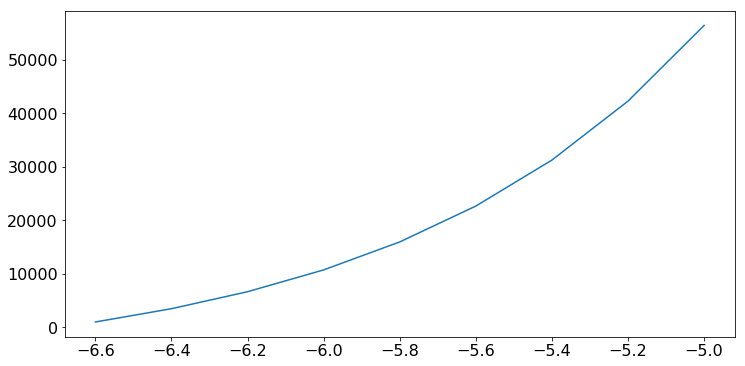

In [46]:
# When the power law approximation can be used, F(rho) above can be solved analytically.

# Or we can do a numerical solution
def F_integrand_approx(rho):
    return powerlaw_approx(rho) / rho + dT_drho_approx(rho)
    
log_mean_density = -6.7

densities_for_approx = valid_densities[valid_densities > -6.7]
F_approx_numerical = [scipy.integrate.quad(
    F_integrand_approx, 10**log_mean_density, 10**upper)[0] for upper in densities_for_approx]

plt.figure()
plt.plot(densities_for_approx, F_approx_numerical);
